# Global Config Paramameters

In [1]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20
PREFETCH_SIZE = 280

# dataset params
DATA_PATH = './pascal_voc_training_data.txt'
IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 6e-6
EPOCHS = 100

# misc
TRAINLOG_NAME = './trainlog.txt'

# Imports and GPU Checks


In [2]:
# Import packages
import os
from operator import itemgetter
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from skimage.util import random_noise

import matplotlib
import matplotlib.pyplot as plt
import cv2

In [3]:
# GPU checks
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,",
            len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

!nvidia-smi

1 Physical GPUs, 1 Logical GPU
Thu Dec  3 01:21:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3070    Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   46C    P2    45W / 220W |    275MiB /  7979MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                         

In [4]:
# Calculate balancing weights for training data
def classes_onehot(clsli):
    onehotli = [0] * 20
    for cls in clsli:
        onehotli[cls] += 1
    return onehotli 

training_data_file = open("./pascal_voc_training_data.txt", "r")
npoh = np.array([classes_onehot ([int(numstr) for numstr in line.strip().split(' ')[5::5]]) for i, line in enumerate(training_data_file)])

ww = (1 / (npoh[:, 14] + 1))
ww /= ww.min()
ww[np.argmin(ww)] = 2
ww /= ww.min()
ww = ww.round()
BALANCE_WEIGHTS = ww.astype('int').tolist()

nnpoh = np.tile(ww, (4974, 1)).dot(npoh)
nnpoh /= nnpoh.min()
(nnpoh.round().mean(), nnpoh.round().std())

(2.55, 1.829617446353199)

# Augmentation

Utilities to get transform matrix from transform dictionary.

In [5]:
# Define functions for transformation matrix calculation
# Adapted from this:
# <https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/affine_transformations.py>

def transform_matrix_offset_center(matrix, x, y):
    """
    Left and right multiply a transform matrix by translations,
    to make all operations performed relative to the center of an image
    """
    o_x = float(x) / 2
    o_y = float(y) / 2
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def get_transform_matrix(transf):
    """
    Generate a transform matrix for bounding boxes,
    from the transformation dictionary used by Keras ImageDataGenerator
    """
    theta, tx, ty, shear, zx, zy = itemgetter(
        'theta', 'tx', 'ty', 'shear', 'zx', 'zy'
    )(transf)
    transform_matrix = None
    if theta != 0:
        theta = np.deg2rad(-theta)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                    [np.sin(theta), np.cos(theta), 0],
                                    [0, 0, 1]])
        transform_matrix = rotation_matrix

    if tx != 0 or ty != 0:
        shift_matrix = np.array([[1, 0, -tx],
                                 [0, 1, -ty],
                                 [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = shift_matrix
        else:
            transform_matrix = np.dot(transform_matrix, shift_matrix)

    if shear != 0:
        shear = np.deg2rad(shear)
        shear_matrix = np.array([[1, np.tan(shear), 0],
                                 [0, 1 / np.cos(shear), 0],
                                 [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = shear_matrix
        else:
            transform_matrix = np.dot(transform_matrix, shear_matrix)

    if zx != 1 or zy != 1:
        zoom_matrix = np.array([[1 / (zx + 1e-7), 0, 0],
                                [0, 1 / (zy + 1e-7), 0],
                                [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = zoom_matrix
        else:
            transform_matrix = np.dot(transform_matrix, zoom_matrix)
    return transform_matrix

Define the augmentation function and its wrapper.

In [6]:
# Define augmentation functions

def augment(image, xct, yct, box_w, box_h, class_num):
    """
    Randomly transform an image of size (448, 448) into augmented image,
    and transform the bounding boxes of objects accordingly.
    
    Input range: [0, 1]
    Output range: [0, 255]
    """
    idg = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=5,
        brightness_range=(0.8, 1.2),
        zoom_range=(0.85, 1.15),
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=4.0,
        fill_mode='constant',
        cval=0.5,
    )
    transf = idg.get_random_transform(image.shape)
    transf_mat = get_transform_matrix(transf)
    transf_mat = transform_matrix_offset_center(transf_mat, 448, 448)
    transf_mat[:, [0, 1]] = transf_mat[:, [1, 0]]
    transf_mat[[0, 1]] = transf_mat[[1, 0]]

    new_xcs = np.zeros(xct.shape)
    new_ycs = np.zeros(yct.shape)
    new_box_ws = np.zeros(box_w.shape)
    new_box_hs = np.zeros(box_h.shape)

    for i in range(0, 20):
        if xct[i] == 0 and yct[i] == 0 and box_w[i] == 0 and box_h[i] == 0:
            break

        # Half widths
        sx = box_w[i] / 2
        sy = box_h[i] / 2
    
        xa, ya, _ = transf_mat.dot(np.array([[xct[i] - sx, yct[i] - sy, 1.]]).T)
        xb, yb, _ = transf_mat.dot(np.array([[xct[i] - sx, yct[i] + sy, 1.]]).T)
        xc, yc, _ = transf_mat.dot(np.array([[xct[i] + sx, yct[i] - sy, 1.]]).T)
        xd, yd, _ = transf_mat.dot(np.array([[xct[i] + sx, yct[i] + sy, 1.]]).T)
        xs = np.hstack([xa, xb, xc, xd])
        ys = np.hstack([ya, yb, yc, yd])

        xl = np.clip(np.min(xs), 0., 448.)
        xr = np.clip(np.max(xs), 0., 448.)
        yl = np.clip(np.min(ys), 0., 448.)
        yr = np.clip(np.max(ys), 0., 448.)
    
        new_box_w = np.clip(xr - xl, 0., 448.)
        new_box_h = np.clip(yr - yl, 0., 448.)

        new_xc = (xl + xr) / 2
        new_yc = (yl + yr) / 2

        if transf['flip_horizontal'] == 1:
            new_xc = 448. - new_xc
        
        new_xcs[i] = new_xc
        new_ycs[i] = new_yc
        new_box_ws[i] = new_box_w
        new_box_hs[i] = new_box_h

    noise_lvl = np.max([np.random.normal(loc=0.003, scale=0.005), 0])
    image = random_noise(image, mode='gaussian', var=noise_lvl)
    image = idg.apply_transform(image, transf)
    return (
        image.astype(np.float32),
        new_xcs.astype(np.float32), new_ycs.astype(np.float32),
        new_box_ws.astype(np.float32), new_box_hs.astype(np.float32)
    )

def py_augment(image, xcenter, ycenter, box_w, box_h, class_num):
    return tf.numpy_function(
        augment, [image, xcenter, ycenter, box_w, box_h, class_num],
        [tf.float32, tf.float32, tf.float32, tf.float32, tf.float32]
    )

# Dataset

Define the dataset generator

In [7]:
# Define the DatasetGenerator class
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self, is_vgg16=True):
        self.balw = tf.constant(BALANCE_WEIGHTS)
        self.is_vgg16 = is_vgg16
        self.image_indexes = []
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')

        last_index = 0
        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])
            self.image_indexes.append(last_index)
            last_index += 1

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # Map from [0, 256) to [0, 1)
        image = image / 255

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio
        
        ### Augmentation
        # Transform the image and boxes
        # Range is now [0, 255]
        image, xcenter, ycenter, box_w, box_h = py_augment(
            tf.cast(image, tf.float32),
            tf.cast(xcenter, tf.float32),
            tf.cast(ycenter, tf.float32),
            tf.cast(box_w, tf.float32),
            tf.cast(box_h, tf.float32),
            tf.cast(class_num, tf.float32)
        )
        # Preprocess into VGG16 format
        # Range is now unknown (?)
        if self.is_vgg16:
            image = tf.keras.applications.vgg16.preprocess_input(image)
        ################

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)
    
    def generate(self, debug=0):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_indexes,
                                                      self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))

        # Used only in non-debug mode.
        #  - Repeating some images
        #  - Shuffling
        if debug == 0:
            dataset = dataset.flat_map(
                lambda idx, name, lbl, objnum: tf.data.Dataset.from_tensors((name, lbl, objnum)).repeat(
                    tf.cast(self.balw[idx], tf.int64))
            )
            dataset = dataset.shuffle(100000)
        # Used only in debug mode.
        #  - Filter data w/ idx NOT in debug_gen_rng
        #  - Remove the "idx" column, to match non-debug branch behavior
        else:
            dataset = dataset.map(
                lambda idx, name, lbl, objnum: (name, lbl, objnum),
                num_parallel_calls = tf.data.experimental.AUTOTUNE
            )

        # Preprocessing for debug & non-debug mode are exactly the same
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.map(lambda image, labels, object_num: (tf.image.random_contrast(
            image, 0.8, 1.2,
        ), labels, object_num), num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.map(lambda image, labels, object_num: (tf.image.random_hue(
            image, 0.02,
        ), labels, object_num), num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.map(lambda image, labels, object_num: (tf.image.random_saturation(
            image, 0.75, 1.2,
        ), labels, object_num), num_parallel_calls = tf.data.experimental.AUTOTUNE)

        # Used only in non-debug mode.
        #  - Batching
        #  - Prefetching
        if debug == 0:
            dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
            dataset = dataset.prefetch(buffer_size=PREFETCH_SIZE)

        return dataset

Ensure that data augmentation is working

框框: 148.0 263.0 210.0 427.0
框框: 212.5 325.0 295.5 447.0
框框: 366.5 293.0 429.5 447.0
框框: 171.0 240.5 225.0 375.5
框框: 156.0 232.0 188.0 276.0
MIN/MAX/MEAN: 0.0 1.0 0.38131657


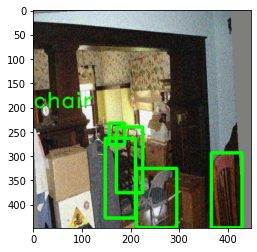

框框: 65.5 99.0 406.5 447.0
MIN/MAX/MEAN: 0.0 1.0 0.4168792


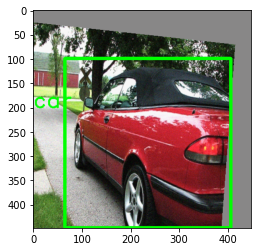

框框: 66.0 206.0 238.0 386.0
框框: 134.5 180.5 205.5 335.5
框框: 244.0 252.5 284.0 391.5
框框: 221.0 248.0 259.0 388.0
MIN/MAX/MEAN: 0.0 1.0 0.39356858


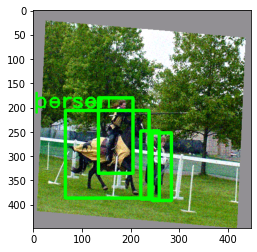

框框: 151.0 145.5 333.0 368.5
MIN/MAX/MEAN: 0.0 1.0 0.3933508


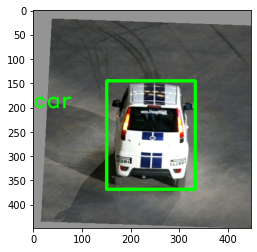

框框: 75.0 76.0 333.0 424.0
MIN/MAX/MEAN: 0.0 1.0 0.3774168


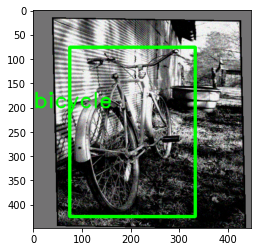

框框: 181.0 108.0 285.0 262.0
框框: 44.5 120.0 381.5 418.0
MIN/MAX/MEAN: 0.0 1.0 0.48325706


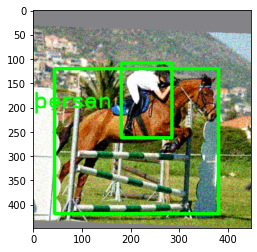

框框: 21.5 126.0 240.5 346.0
框框: 209.5 165.0 430.5 357.0
MIN/MAX/MEAN: 0.0 1.0 0.5436429


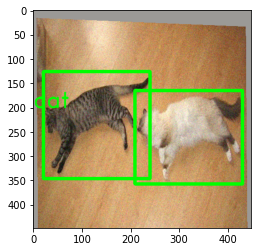

框框: 82.5 144.5 447.5 437.5
MIN/MAX/MEAN: 0.0 1.0 0.29740053


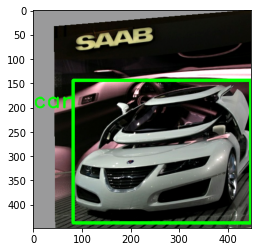

框框: 208.0 222.0 428.0 362.0
框框: 19.5 58.5 172.5 447.5
框框: 221.5 91.0 372.5 341.0
框框: 256.5 175.5 415.5 386.5
MIN/MAX/MEAN: 0.0 1.0 0.4386428


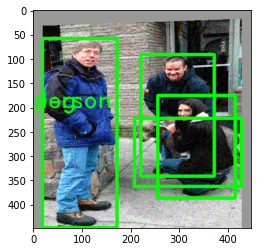

框框: 115.0 167.0 407.0 415.0
框框: 7.0 150.5 139.0 395.5
框框: 303.5 136.5 416.5 415.5
框框: 273.5 0.0 420.5 306.0
框框: 118.5 0.0 419.5 384.0
框框: 7.0 -0.5 149.0 384.5
MIN/MAX/MEAN: 0.0 1.0 0.45521307


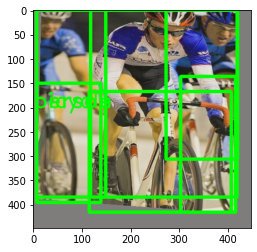

框框: 22.5 190.0 313.5 324.0
MIN/MAX/MEAN: 0.0 1.0 0.49821886


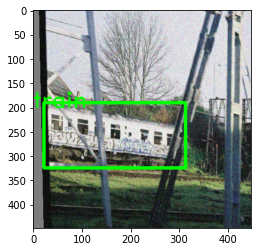

框框: 177.0 130.5 421.0 261.5
MIN/MAX/MEAN: 0.0 1.0 0.46122077


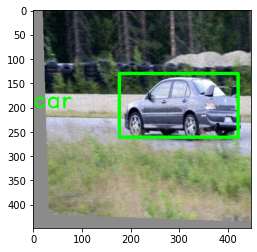

框框: -0.5 243.5 124.5 346.5
框框: 0.0 193.5 94.0 348.5
框框: 243.0 180.5 409.0 361.5
MIN/MAX/MEAN: 0.0 1.0 0.5288832


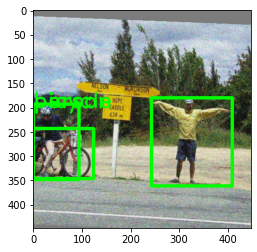

框框: 42.5 80.0 309.5 246.0
框框: 75.0 95.5 139.0 148.5
框框: 125.5 229.0 146.5 299.0
框框: 0.0 229.0 0.0 299.0
MIN/MAX/MEAN: 0.0 1.0 0.4526334


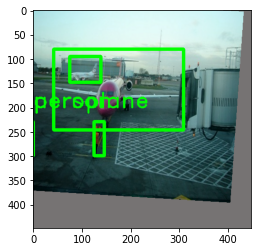

框框: 0.0 120.0 382.0 292.0
框框: 317.5 224.0 366.5 252.0
框框: 241.5 210.0 310.5 248.0
MIN/MAX/MEAN: 0.0 1.0 0.62202936


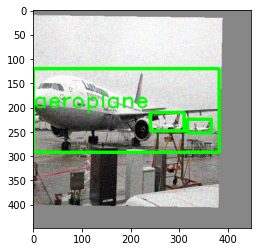

框框: 0.0 153.5 298.0 376.5
框框: 0.0 141.0 260.0 215.0
MIN/MAX/MEAN: 0.0 1.0 0.3572204


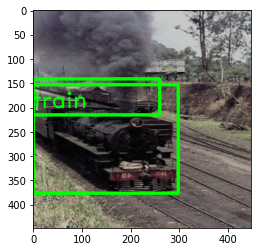

框框: 1.0 119.0 205.0 447.0
框框: 226.5 115.5 447.5 422.5
框框: 448.0 248.0 448.0 416.0
框框: 2.5 398.5 447.5 447.5
MIN/MAX/MEAN: 0.0 1.0 0.3299233


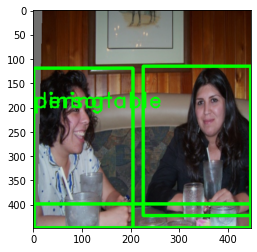

框框: 22.5 26.5 447.5 299.5
MIN/MAX/MEAN: 0.0 1.0 0.5239065


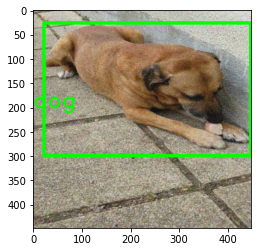

框框: 155.0 149.5 333.0 366.5
MIN/MAX/MEAN: 0.0 1.0 0.5702698


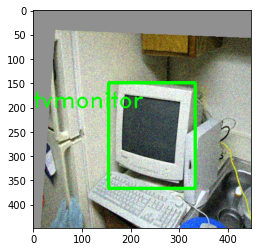

框框: 32.5 31.5 97.5 114.5
框框: 151.0 94.5 237.0 387.5
框框: 227.5 173.0 286.5 307.0
MIN/MAX/MEAN: 0.0 1.0 0.29092336


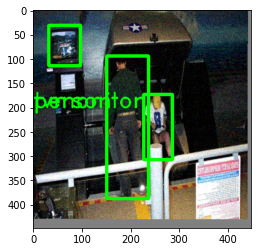

框框: 10.0 37.5 234.0 366.5
框框: 249.0 47.0 447.0 375.0
MIN/MAX/MEAN: 0.0 1.0 0.40155548


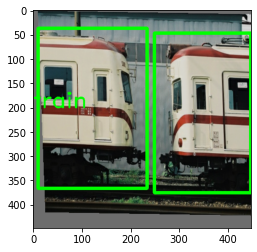

In [8]:
# Test py_augment() and DatasetGenerator
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

def annotate_img_rect(img, lbls, num):
    for i in range(0, 20):
        xc, yc, w, h, class_num = lbls[i, :]
        xmin, ymin, xmax, ymax = xc - w / 2, yc - h / 2, xc + w / 2, yc + h / 2
        
        if xmin == 0 and ymin == 0 and xmax == 0 and ymax == 0:
            return img, True
        
        print('框框:', xmin, ymin, xmax, ymax)
        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 5)
        cv2.putText(
            img, classes_name[class_num],
            (0, 200), 2, 1.5, (0, 255, 0), 2
        )
    return img, False

def test_augmentation():
    dg = DatasetGenerator(is_vgg16=False)
    i = 0
    for img, lbls, num in dg.generate(debug=True):
        if i > 20:
            break
        i += 1
        img = np.clip(np.array(img / 255.), 0., 1.)
        img, should_stop = annotate_img_rect(img, lbls.numpy().astype('int'), num.numpy())
        img = np.clip(img, 0., 1.)
        print('MIN/MAX/MEAN:', img.min(), img.max(), img.mean())
        plt.imshow(img)
        plt.show()
        if should_stop == True:
            continue

test_augmentation()

# Model Definition

Define the model

In [9]:
# Define model architecture and display summary

from tensorflow import keras
from tensorflow.keras import layers

def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)
    return x


img_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=img_shape)
vgg16.trainable = False

img_inputs = keras.Input(shape= img_shape)
x = vgg16(img_inputs)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 2)
x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096, 
                 kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, 
                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

YOLO.summary()

Model: "YOLO"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 14, 14, 512)       14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 1024)      4719616   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 1024)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 1024)        9438208   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 1024)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 1024)        9438208

In [10]:
# Define the loss functions

# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def clip_label(label):
    xct = label[0]
    yct = label[1]
    hw = label[2] / 2
    hh = label[3] / 2
    xmin = tf.clip_by_value(xct - hw, 1., 447.)
    xmax = tf.clip_by_value(xct + hw, 1., 447.)
    ymin = tf.clip_by_value(yct - hh, 1., 447.)
    ymax = tf.clip_by_value(yct + hh, 1., 447.)
    return tf.stack([(xmin + xmax) / 2, (ymin + ymax) / 2, xmax - xmin, ymax - ymin, label[4]])

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])
    label = clip_label(label)

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss


In [11]:
# Create dataset instance, optimizer, checkpoint manager

dataset = DatasetGenerator().generate()

# Optimizer etc.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    LEARNING_RATE,
    decay_steps=40000,
    decay_rate=0.9,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

# Checkpoint
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)
manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO_VGG', max_to_keep=5,
                                     checkpoint_name='yolo')

In [12]:
# Define the training step

@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

# Training

In [13]:
# Try to load state from checkpoint

if manager.latest_checkpoint:
    ckpt.restore(manager.latest_checkpoint).assert_consumed()
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./ckpts/YOLO_VGG/yolo-127


In [14]:
# Define training log output function
# (this is necessary, because jupyter discards output once we disconnect)

def log_train(logstr):
    print(logstr)
    trainlog = open(TRAINLOG_NAME, 'a')
    trainlog.write(logstr + '\n')
    trainlog.close()

Now we run the training loop.

In [ ]:
# Training loop

log_train("{}, start training.".format(datetime.now()))
for _ in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    log_train(f'Learning rate: {optimizer._decayed_lr("float32").numpy()}')
    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)
    
    log_train("{}, Epoch {}: loss {:.2f}".format(datetime.now(), int(ckpt.epoch), train_loss_metric.result()))

    save_path = manager.save()
    log_train("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

# Predict and Evaluate

In [ ]:
# Define utility function: YOLO output -> non-max-suppressed BOUs

def process_outputs(outputs):
    """
    Process YOLO outputs into BOUs
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes

    # Get (1-D) sorted indexes
    P_argsort = P.ravel().argsort()[::-1]
    
    # Construct lists of coordinates for bboxes w/ high enough confidences
    xmins, ymins, xmaxs, ymaxs, class_nums, confs = [], [], [], [], [], []
    for i in range(0, P.size):
        index = np.unravel_index(P_argsort[i], P.shape)
        conf = P[index]
        if conf < 0.03:
            break

        class_num = index[3]
        coordinate = np.reshape(
            coordinate, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4)
        )
    
        max_coordinate = coordinate[index[0], index[1], index[2], :]
    
        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]
    
        xcenter = (index[1] + xcenter) * (IMAGE_SIZE / float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE / float(CELL_SIZE))
    
        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE
    
        xmin = xcenter - w / 2.0
        ymin = ycenter - h / 2.0
    
        xmax = xmin + w
        ymax = ymin + h

        xmins.append(xmin)
        ymins.append(ymin)
        xmaxs.append(xmax)
        ymaxs.append(ymax)
        class_nums.append(class_num)
        confs.append(conf)
 
    # Convert to numpy arrays
    # (because we're going to use numpy arrays to index them anyways)
    # Also the bounding boxes are clipped between 0 and 448
    xmins = np.clip(np.array(xmins), 0., 448.)
    ymins = np.clip(np.array(ymins), 0., 448.)
    xmaxs = np.clip(np.array(xmaxs), 0., 448.)
    ymaxs = np.clip(np.array(ymaxs), 0., 448.)
    class_nums = np.array(class_nums)
    confs = np.array(confs)
   
    # Construct parameters for non-max-suppression from TF
    boxes = tf.constant(np.vstack([ymins, xmins, ymaxs, xmaxs]).T, dtype=tf.float32)
    scores = tf.constant(confs, dtype=tf.float32)

    # Call non-max-suppression
    sel_indexes = tf.image.non_max_suppression(
        boxes, scores, 20, iou_threshold=0.2, name='NONMAX_SUPPRESS'
    ).numpy().astype('int')

    return (
        xmins[sel_indexes], ymins[sel_indexes], xmaxs[sel_indexes], ymaxs[sel_indexes]
        , class_nums[sel_indexes], confs[sel_indexes]
    )

In [ ]:
# Read testing dataset

test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

In [ ]:
# Define utility function: image name -> image and its dimensions

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.keras.applications.vgg16.preprocess_input(image)

    return image_name, image, h, w


Now we run the prediction loop

In [ ]:
# Prediction loop
test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)
ckpt.restore(manager.latest_checkpoint)

@tf.function
def prediction_step(img):
    return YOLO(img, training=False)

output_file = open('./test_prediction.txt', 'w')

print("{}, start predicting".format(datetime.now()))
for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmins, ymins, xmaxs, ymaxs, class_nums, confs = process_outputs(prediction_step(test_img[i:i+1]))
        for j in range(0, len(xmins)):
            xmin, ymin, xmax, ymax, class_num, conf =\
                xmins[j], ymins[j], xmaxs[j], ymaxs[j], class_nums[j], confs[j]
            xmin, ymin, xmax, ymax =\
                xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
    
            #img filename, xmin, ymin, xmax, ymax, class, confidence
            output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))
print("{}, end predicting".format(datetime.now()))

output_file.close()

In [ ]:
# Use the supplied evaluate module to create output file for submission
import sys
sys.path.insert(0, './evaluate')

import evaluate
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

# Visualization

Define utility functions for visualization

In [ ]:
# Define utility functions for drawing boxes, showing predictions, and showing ground truths
%matplotlib inline

classes_name = ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                "bus", "car", "cat", "chair", "cow", "diningtable", 
                "dog", "horse", "motorbike", "person", "pottedplant", 
                "sheep", "sofa", "train","tvmonitor"]

def annotate_img_rect(img, xmin, ymin, xmax, ymax, num, color=(255, 255, 0)):
    cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, 2)
    cv2.putText(img, classes_name[num], (int(xmin) + 10, int(ymin) + 30), 2, 0.8, color, 2)
    return img

def show_predict_img(idx, dataset='train'):
    np_img = cv2.imread(f'./VOCdevkit_{dataset}/VOC2007/JPEGImages/{idx:06}.jpg')
    resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    resized_img = np_img
    np_img = np_img.astype(np.float32)
    image = tf.keras.applications.vgg16.preprocess_input(np_img)
    np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    
    y_pred = YOLO(np_img, training=False)
    xmins, ymins, xmaxs, ymaxs, class_nums, confs = process_outputs(y_pred)
    print('CLASS_NUMS', class_nums)
    original = False
    color = (0, 255, 0)
    if original:
        xmin, ymin, xmax, ymax, cls_num, conf =\
            xmins, ymins, xmaxs, ymaxs, class_nums, confs
        print('PREDICT', xmin, ymin, xmax, ymax, classes_name[cls_num], conf)
        resized_img = annotate_img_rect(resized_img, xmin, ymin, xmax, ymax, cls_num, color=color)
    else:
        for i in range(0, len(xmins)):
            xmin, ymin, xmax, ymax, cls_num, conf =\
                xmins[i], ymins[i], xmaxs[i], ymaxs[i], class_nums[i], confs[i]
            class_name = classes_name[class_num]
            print('PREDICT', xmin, ymin, xmax, ymax, classes_name[cls_num], conf)
            resized_img = annotate_img_rect(resized_img, xmin, ymin, xmax, ymax, cls_num, color=color)
 
    plt.imshow(resized_img)
    plt.show()

def show_ground_truth_img(idx):
    np_img = cv2.imread(f'./VOCdevkit_train/VOC2007/JPEGImages/{idx:06}.jpg')
    h, w, _ = np_img.shape
    resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    resized_img = np_img
    np_img = np_img.astype(np.float32)
    np_img = np_img / 255.0 * 2 - 1
    np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))
 
    true_data = {line.split(' ')[0] : np.array(
        list(map(lambda s: int(s), line.strip().split(' ')[1:]))
    ).reshape((-1, 5)).astype('int') for line in open(DATA_PATH, 'r')}
    fname = f'{idx_to_show:06}.jpg'
    for i in range(true_data[fname].shape[0]):
        xmin, ymin, xmax, ymax, class_num = true_data[fname][i, :]
        xmin = xmin / w * IMAGE_SIZE
        xmax = xmax / w * IMAGE_SIZE
        ymin = ymin / h * IMAGE_SIZE
        ymax = ymax / h * IMAGE_SIZE
        print(xmin, ymin, xmax, ymax, classes_name[class_num])
        resized_img = annotate_img_rect(resized_img, xmin, ymin, xmax, ymax, class_num)
    plt.imshow(resized_img)
    plt.show()

In [ ]:
# Visualize some of the predictions

# List of all testing data numbers (warning: it's VERY long)
testnums = [
    1, 2, 3, 4, 6, 8, 10, 11, 13, 14, 15, 18, 22, 25, 27, 28, 29, 31, 37, 38, 40, 43, 45, 49, 53, 54, 55, 56, 57, 58, 59, 62, 67, 68, 69, 70, 71, 74, 75, 76, 79, 80, 82, 84, 85, 86, 87, 88, 90, 92, 94, 96, 97, 98, 100, 103, 105, 106, 108, 111, 114, 115, 116, 119, 124, 126, 127, 128, 135, 136, 137, 139, 144, 145, 148, 149, 151, 152, 155, 157, 160, 166, 167, 168, 172, 175, 176, 178, 179, 181, 182, 183, 185, 186, 188, 191, 195, 196, 197, 199, 201, 202, 204, 205, 206, 212, 213, 216, 217, 223, 226, 227, 230, 231, 234, 237, 238, 239, 240, 243, 247, 248, 252, 253, 254, 255, 258, 260, 261, 264, 265, 267, 271, 272, 273, 274, 277, 279, 280, 281, 283, 284, 286, 287, 290, 291, 292, 293, 295, 297, 299, 300, 301, 309, 310, 313, 314, 315, 316, 319, 324, 326, 327, 330, 333, 335, 339, 341, 342, 345, 346, 348, 350, 351, 353, 356, 357, 358, 360, 361, 362, 364, 365, 366, 368, 369, 371, 375, 376, 377, 378, 383, 384, 385, 386, 388, 389, 390, 392, 393, 397, 398, 399, 401, 402, 405, 409, 410, 412, 413, 414, 415, 418, 421, 422, 423, 425, 426, 429, 432, 434, 436, 437, 440, 441, 442, 444, 445, 447, 449, 451, 452, 453, 455, 456, 457, 458, 465, 466, 467, 471, 472, 473, 475, 478, 479, 481, 485, 487, 488, 490, 493, 495, 497, 502, 504, 505, 506, 507, 510, 511, 512, 517, 521, 527, 529, 532, 533, 534, 536, 538, 539, 542, 546, 547, 548, 551, 553, 556, 557, 558, 560, 561, 562, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 578, 580, 584, 585, 586, 587, 593, 594, 595, 596, 600, 602, 603, 604, 606, 607, 611, 614, 615, 616, 617, 618, 621, 623, 624, 627, 629, 630, 631, 634, 636, 638, 639, 640, 641, 642, 643, 644, 646, 649, 650, 651, 652, 655, 658, 659, 662, 664, 665, 666, 668, 669, 670, 673, 674, 678, 679, 681, 683, 687, 691, 692, 693, 696, 697, 698, 701, 703, 704, 706, 708, 715, 716, 718, 719, 721, 722, 723, 724, 725, 727, 732, 734, 735, 736, 737, 741, 743, 744, 745, 747, 749, 751, 757, 758, 759, 762, 765, 766, 769, 773, 775, 778, 779, 781, 783, 784, 785, 788, 789, 790, 792, 795, 798, 801, 803, 807, 809, 811, 813, 817, 819, 821, 824, 825, 833, 835, 836, 837, 838, 839, 840, 841, 844, 846, 852, 853, 856, 858, 861, 864, 866, 869, 870, 873, 875, 877, 881, 883, 884, 886, 890, 891, 893, 894, 897, 901, 905, 907, 909, 910, 913, 914, 916, 922, 924, 925, 927, 928, 930, 932, 933, 938, 939, 940, 941, 942, 944, 945, 952, 953, 955, 956, 957, 959, 960, 961, 963, 968, 969, 970, 974, 975, 976, 978, 979, 981, 983, 984, 985, 986, 988, 990, 992, 994, 995, 998, 1000, 1003, 1005, 1006, 1007, 1013, 1016, 1019, 1020, 1021, 1022, 1023, 1025, 1026, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1037, 1038, 1039, 1040, 1044, 1046, 1047, 1048, 1049, 1051, 1054, 1055, 1058, 1059, 1063, 1065, 1067, 1070, 1075, 1076, 1080, 1081, 1085, 1086, 1087, 1088, 1089, 1090, 1094, 1095, 1096, 1098, 1099, 1100, 1103, 1105, 1108, 1111, 1114, 1115, 1116, 1117, 1118, 1120, 1122, 1123, 1126, 1128, 1131, 1132, 1133, 1134, 1135, 1138, 1139, 1141, 1146, 1150, 1153, 1155, 1157, 1159, 1162, 1163, 1165, 1167, 1169, 1173, 1177, 1178, 1179, 1180, 1181, 1183, 1188, 1189, 1190, 1193, 1195, 1196, 1197, 1198, 1202, 1208, 1210, 1213, 1216, 1217, 1218, 1219, 1220, 1222, 1223, 1227, 1228, 1232, 1235, 1238, 1242, 1243, 1244, 1245, 1246, 1249, 1251, 1252, 1253, 1255, 1256, 1257, 1261, 1262, 1264, 1267, 1271, 1275, 1276, 1278, 1280, 1282, 1283, 1285, 1291, 1295, 1296, 1297, 1300, 1301, 1302, 1303, 1305, 1306, 1307, 1308, 1313, 1317, 1318, 1319, 1320, 1321, 1322, 1328, 1329, 1331, 1335, 1336, 1338, 1339, 1340, 1342, 1344, 1347, 1349, 1351, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1363, 1366, 1367, 1368, 1369, 1370, 1372, 1373, 1374, 1376, 1377, 1379, 1380, 1381, 1382, 1389, 1391, 1392, 1394, 1396, 1398, 1399, 1401, 1403, 1407, 1410, 1411, 1412, 1415, 1416, 1417, 1419, 1422, 1423, 1424, 1425, 1428, 1429, 1431, 1433, 1435, 1437, 1438, 1440, 1446, 1447, 1448, 1449, 1452, 1454, 1456, 1458, 1459, 1461, 1462, 1469, 1471, 1473, 1474, 1476, 1477, 1478, 1482, 1487, 1489, 1491, 1495, 1496, 1500, 1502, 1503, 1505, 1506, 1507, 1508, 1511, 1513, 1516, 1518, 1519, 1520, 1525, 1527, 1530, 1533, 1534, 1535, 1538, 1540, 1542, 1546, 1547, 1549, 1550, 1551, 1552, 1558, 1560, 1562, 1564, 1566, 1567, 1568, 1569, 1570, 1572, 1573, 1574, 1575, 1578, 1581, 1583, 1584, 1585, 1587, 1589, 1591, 1592, 1596, 1599, 1600, 1601, 1602, 1605, 1606, 1609, 1613, 1615, 1616, 1619, 1620, 1621, 1623, 1624, 1625, 1626, 1629, 1631, 1634, 1635, 1637, 1639, 1641, 1644, 1645, 1646, 1648, 1652, 1655, 1656, 1657, 1658, 1659, 1660, 1663, 1664, 1665, 1666, 1667, 1668, 1670, 1671, 1672, 1674, 1679, 1681, 1687, 1692, 1694, 1695, 1696, 1697, 1698, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1709, 1710, 1712, 1715, 1716, 1719, 1720, 1722, 1728, 1731, 1735, 1736, 1737, 1740, 1742, 1743, 1744, 1745, 1748, 1751, 1753, 1757, 1760, 1762, 1763, 1764, 1767, 1769, 1770, 1773, 1774, 1776, 1779, 1781, 1783, 1786, 1788, 1790, 1791, 1792, 1794, 1796, 1798, 1802, 1803, 1804, 1805, 1808, 1811, 1812, 1813, 1814, 1815, 1817, 1819, 1820, 1822, 1823, 1824, 1826, 1829, 1831, 1835, 1838, 1839, 1844, 1846, 1848, 1850, 1851, 1852, 1856, 1857, 1859, 1863, 1865, 1866, 1867, 1868, 1869, 1871, 1873, 1874, 1876, 1879, 1880, 1883, 1884, 1885, 1886, 1889, 1890, 1891, 1893, 1895, 1897, 1900, 1905, 1908, 1909, 1910, 1912, 1913, 1914, 1916, 1917, 1919, 1921, 1923, 1924, 1925, 1926, 1929, 1935, 1939, 1942, 1943, 1946, 1947, 1949, 1951, 1953, 1955, 1956, 1957, 1959, 1961, 1965, 1966, 1967, 1968, 1969, 1973, 1974, 1975, 1979, 1983, 1984, 1986, 1987, 1988, 1990, 1991, 1992, 1993, 1994, 1996, 1997, 1998, 2003, 2005, 2007, 2008, 2009, 2010, 2013, 2014, 2016, 2017, 2018, 2026, 2028, 2029, 2031, 2032, 2033, 2035, 2038, 2040, 2041, 2044, 2046, 2048, 2050, 2052, 2053, 2057, 2059, 2060, 2062, 2065, 2066, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2084, 2085, 2087, 2089, 2092, 2093, 2097, 2100, 2103, 2105, 2106, 2107, 2110, 2111, 2113, 2115, 2118, 2119, 2121, 2122, 2123, 2127, 2128, 2130, 2131, 2133, 2137, 2138, 2141, 2143, 2144, 2147, 2148, 2149, 2150, 2154, 2157, 2159, 2160, 2161, 2162, 2164, 2167, 2168, 2173, 2175, 2177, 2185, 2188, 2189, 2195, 2198, 2200, 2203, 2204, 2205, 2206, 2207, 2210, 2211, 2216, 2217, 2222, 2223, 2225, 2227, 2229, 2230, 2231, 2232, 2235, 2236, 2239, 2240, 2242, 2243, 2245, 2246, 2250, 2252, 2254, 2258, 2262, 2264, 2269, 2271, 2274, 2275, 2282, 2283, 2286, 2289, 2292, 2294, 2295, 2296, 2297, 2298, 2299, 2301, 2303, 2304, 2309, 2312, 2313, 2314, 2316, 2317, 2319, 2322, 2325, 2326, 2327, 2331, 2336, 2338, 2339, 2341, 2344, 2346, 2349, 2351, 2353, 2356, 2357, 2358, 2360, 2363, 2365, 2370, 2379, 2380, 2381, 2383, 2386, 2388, 2389, 2390, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2402, 2406, 2408, 2409, 2412, 2414, 2416, 2418, 2421, 2422, 2424, 2426, 2428, 2429, 2430, 2431, 2432, 2434, 2438, 2440, 2446, 2447, 2449, 2451, 2453, 2455, 2457, 2463, 2464, 2467, 2469, 2473, 2474, 2475, 2482, 2484, 2485, 2486, 2487, 2488, 2489, 2495, 2498, 2499, 2503, 2506, 2507, 2509, 2510, 2511, 2515, 2516, 2517, 2521, 2522, 2526, 2527, 2528, 2530, 2531, 2532, 2535, 2536, 2538, 2541, 2543, 2548, 2550, 2551, 2552, 2553, 2556, 2557, 2560, 2562, 2568, 2570, 2573, 2574, 2575, 2576, 2577, 2580, 2581, 2582, 2583, 2587, 2588, 2591, 2592, 2596, 2597, 2601, 2602, 2604, 2607, 2608, 2610, 2612, 2614, 2616, 2617, 2619, 2620, 2622, 2623, 2624, 2626, 2628, 2629, 2630, 2631, 2638, 2639, 2640, 2642, 2644, 2650, 2651, 2652, 2654, 2655, 2656, 2660, 2661, 2663, 2665, 2671, 2672, 2673, 2674, 2676, 2679, 2681, 2685, 2686, 2687, 2688, 2692, 2694, 2698, 2700, 2701, 2703, 2705, 2707, 2708, 2711, 2712, 2716, 2719, 2720, 2724, 2725, 2726, 2728, 2729, 2731, 2733, 2736, 2739, 2740, 2742, 2743, 2746, 2748, 2750, 2752, 2753, 2754, 2756, 2758, 2761, 2764, 2768, 2769, 2770, 2771, 2773, 2777, 2780, 2781, 2787, 2788, 2789, 2790, 2792, 2793, 2797, 2799, 2802, 2805, 2806, 2808, 2809, 2811, 2813, 2814, 2818, 2819, 2821, 2822, 2823, 2824, 2825, 2828, 2829, 2830, 2831, 2832, 2837, 2839, 2840, 2843, 2846, 2849, 2850, 2851, 2852, 2853, 2856, 2857, 2860, 2861, 2862, 2863, 2865, 2871, 2872, 2874, 2876, 2877, 2878, 2882, 2883, 2885, 2887, 2888, 2890, 2892, 2894, 2895, 2897, 2898, 2900, 2902, 2903, 2904, 2905, 2907, 2908, 2909, 2911, 2918, 2920, 2921, 2922, 2923, 2925, 2926, 2927, 2928, 2929, 2930, 2936, 2945, 2948, 2949, 2950, 2951, 2955, 2959, 2961, 2964, 2968, 2970, 2971, 2972, 2973, 2974, 2979, 2980, 2981, 2982, 2983, 2985, 2991, 2993, 2996, 2997, 2998, 2999, 3001, 3006, 3010, 3012, 3014, 3016, 3018, 3019, 3020, 3022, 3025, 3026, 3029, 3030, 3033, 3035, 3036, 3037, 3040, 3041, 3043, 3046, 3048, 3049, 3050, 3052, 3055, 3059, 3060, 3062, 3067, 3068, 3069, 3070, 3071, 3073, 3075, 3076, 3079, 3080, 3081, 3084, 3087, 3091, 3095, 3096, 3097, 3099, 3101, 3104, 3109, 3111, 3113, 3114, 3115, 3119, 3123, 3125, 3128, 3130, 3131, 3132, 3136, 3139, 3141, 3143, 3144, 3148, 3151, 3152, 3153, 3156, 3158, 3160, 3166, 3167, 3168, 3171, 3172, 3173, 3174, 3179, 3180, 3182, 3187, 3190, 3191, 3192, 3193, 3196, 3197, 3198, 3201, 3203, 3206, 3208, 3209, 3212, 3215, 3217, 3220, 3221, 3222, 3224, 3225, 3226, 3227, 3230, 3232, 3234, 3235, 3237, 3238, 3241, 3245, 3246, 3248, 3249, 3251, 3252, 3257, 3263, 3264, 3265, 3266, 3267, 3268, 3275, 3276, 3277, 3278, 3281, 3283, 3286, 3287, 3288, 3289, 3291, 3295, 3297, 3298, 3302, 3304, 3305, 3306, 3309, 3310, 3312, 3314, 3315, 3317, 3318, 3319, 3321, 3322, 3323, 3324, 3326, 3328, 3329, 3332, 3333, 3334, 3340, 3341, 3342, 3345, 3346, 3347, 3348, 3352, 3353, 3357, 3358, 3361, 3364, 3366, 3368, 3371, 3372, 3375, 3378, 3381, 3383, 3384, 3385, 3387, 3388, 3389, 3393, 3394, 3399, 3400, 3402, 3405, 3409, 3411, 3414, 3418, 3423, 3426, 3427, 3428, 3431, 3432, 3434, 3437, 3438, 3440, 3442, 3445, 3446, 3447, 3448, 3454, 3456, 3457, 3459, 3460, 3463, 3467, 3471, 3472, 3473, 3474, 3475, 3476, 3478, 3479, 3480, 3481, 3482, 3483, 3485, 3486, 3488, 3490, 3494, 3495, 3498, 3501, 3502, 3503, 3504, 3505, 3507, 3512, 3513, 3514, 3515, 3517, 3520, 3523, 3526, 3527, 3531, 3532, 3533, 3534, 3535, 3538, 3540, 3541, 3542, 3543, 3544, 3545, 3547, 3552, 3553, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3578, 3579, 3581, 3582, 3583, 3584, 3590, 3591, 3592, 3595, 3598, 3600, 3601, 3602, 3607, 3610, 3612, 3613, 3615, 3616, 3617, 3619, 3624, 3626, 3630, 3631, 3633, 3637, 3641, 3643, 3647, 3649, 3650, 3652, 3653, 3659, 3661, 3665, 3666, 3668, 3670, 3672, 3676, 3677, 3680, 3682, 3683, 3686, 3687, 3689, 3692, 3693, 3697, 3701, 3702, 3707, 3710, 3712, 3715, 3716, 3718, 3719, 3720, 3723, 3724, 3725, 3726, 3728, 3730, 3731, 3733, 3734, 3736, 3737, 3738, 3739, 3741, 3742, 3744, 3745, 3746, 3747, 3755, 3756, 3757, 3761, 3762, 3764, 3765, 3766, 3768, 3769, 3770, 3771, 3775, 3776, 3777, 3778, 3782, 3785, 3787, 3789, 3794, 3795, 3799, 3800, 3801, 3802, 3804, 3805, 3810, 3812, 3813, 3815, 3816, 3819, 3822, 3823, 3825, 3829, 3831, 3832, 3833, 3836, 3839, 3840, 3841, 3842, 3843, 3850, 3851, 3852, 3853, 3854, 3858, 3862, 3864, 3867, 3870, 3873, 3875, 3878, 3880, 3881, 3882, 3883, 3884, 3888, 3892, 3893, 3894, 3896, 3897, 3900, 3901, 3902, 3903, 3904, 3906, 3908, 3909, 3910, 3914, 3916, 3917, 3920, 3922, 3925, 3927, 3928, 3929, 3930, 3931, 3933, 3934, 3938, 3940, 3942, 3943, 3944, 3950, 3951, 3952, 3955, 3958, 3959, 3962, 3964, 3967, 3968, 3972, 3975, 3976, 3977, 3978, 3980, 3981, 3982, 3985, 3989, 3995, 3999, 4000, 4001, 4002, 4004, 4006, 4007, 4018, 4021, 4022, 4024, 4026, 4027, 4029, 4030, 4032, 4036, 4038, 4040, 4041, 4042, 4043, 4044, 4045, 4048, 4049, 4050, 4053, 4054, 4055, 4056, 4059, 4061, 4062, 4063, 4064, 4065, 4068, 4070, 4071, 4072, 4074, 4078, 4079, 4080, 4081, 4083, 4084, 4086, 4088, 4090, 4094, 4096, 4097, 4098, 4099, 4101, 4103, 4104, 4107, 4109, 4112, 4114, 4115, 4116, 4118, 4119, 4123, 4124, 4125, 4126, 4127, 4128, 4130, 4132, 4134, 4139, 4144, 4147, 4151, 4153, 4154, 4155, 4156, 4157, 4159, 4160, 4161, 4162, 4165, 4166, 4167, 4172, 4173, 4175, 4176, 4177, 4179, 4180, 4181, 4182, 4183, 4184, 4187, 4188, 4197, 4198, 4199, 4202, 4206, 4207, 4208, 4210, 4211, 4213, 4214, 4216, 4217, 4218, 4219, 4222, 4225, 4226, 4227, 4233, 4234, 4235, 4236, 4238, 4240, 4243, 4245, 4248, 4249, 4250, 4251, 4252, 4254, 4260, 4261, 4262, 4266, 4267, 4268, 4276, 4277, 4278, 4282, 4285, 4288, 4289, 4290, 4294, 4297, 4299, 4301, 4302, 4305, 4306, 4308, 4309, 4311, 4313, 4314, 4316, 4317, 4319, 4320, 4324, 4328, 4330, 4332, 4334, 4335, 4336, 4337, 4340, 4342, 4343, 4344, 4348, 4350, 4353, 4355, 4357, 4358, 4362, 4363, 4366, 4373, 4374, 4375, 4377, 4378, 4381, 4382, 4383, 4385, 4388, 4393, 4394, 4395, 4398, 4399, 4400, 4401, 4402, 4403, 4406, 4407, 4408, 4410, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4422, 4425, 4426, 4427, 4428, 4431, 4435, 4440, 4442, 4443, 4444, 4445, 4447, 4448, 4449, 4451, 4453, 4454, 4456, 4458, 4460, 4461, 4462, 4465, 4467, 4469, 4472, 4473, 4475, 4476, 4477, 4478, 4480, 4482, 4483, 4485, 4486, 4489, 4491, 4492, 4497, 4501, 4503, 4504, 4505, 4506, 4511, 4513, 4515, 4516, 4521, 4522, 4523, 4525, 4529, 4531, 4533, 4534, 4536, 4538, 4541, 4543, 4545, 4546, 4547, 4550, 4554, 4556, 4557, 4559, 4560, 4561, 4564, 4567, 4568, 4569, 4572, 4573, 4575, 4577, 4578, 4580, 4582, 4583, 4586, 4589, 4590, 4593, 4594, 4596, 4598, 4599, 4602, 4603, 4608, 4610, 4613, 4614, 4615, 4616, 4617, 4619, 4620, 4621, 4624, 4629, 4633, 4635, 4637, 4638, 4639, 4640, 4641, 4642, 4645, 4646, 4650, 4657, 4658, 4659, 4661, 4663, 4664, 4665, 4666, 4667, 4668, 4669, 4670, 4677, 4678, 4680, 4681, 4684, 4688, 4690, 4695, 4696, 4697, 4698, 4700, 4703, 4704, 4709, 4711, 4712, 4713, 4716, 4717, 4720, 4721, 4724, 4725, 4726, 4728, 4729, 4730, 4731, 4733, 4734, 4736, 4738, 4739, 4740, 4741, 4744, 4745, 4749, 4751, 4752, 4755, 4756, 4757, 4758, 4759, 4762, 4763, 4764, 4765, 4766, 4767, 4769, 4771, 4772, 4774, 4775, 4778, 4780, 4781, 4784, 4787, 4791, 4795, 4798, 4800, 4802, 4803, 4804, 4806, 4807, 4809, 4810, 4811, 4813, 4817, 4819, 4820, 4821, 4822, 4824, 4827, 4829, 4833, 4835, 4838, 4843, 4844, 4845, 4847, 4851, 4853, 4854, 4855, 4858, 4860, 4861, 4862, 4864, 4865, 4870, 4871, 4874, 4875, 4877, 4880, 4881, 4883, 4884, 4887, 4888, 4889, 4891, 4892, 4893, 4894, 4899, 4900, 4901, 4904, 4906, 4908, 4909, 4914, 4915, 4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925, 4927, 4930, 4932, 4933, 4934, 4937, 4940, 4941, 4942, 4944, 4945, 4947, 4949, 4952, 4957, 4959, 4964, 4965, 4969, 4970, 4971, 4975, 4978, 4979, 4980, 4981, 4988, 4989, 4993, 4996, 5000, 5002, 5005, 5008, 5009, 5010, 5011, 5012, 5013, 5015, 5017, 5019, 5021, 5022, 5025, 5030, 5031, 5034, 5035, 5038, 5040, 5041, 5043, 5044, 5046, 5048, 5049, 5050, 5051, 5053, 5059, 5060, 5066, 5069, 5070, 5074, 5075, 5076, 5080, 5082, 5083, 5087, 5088, 5089, 5091, 5092, 5095, 5096, 5098, 5099, 5100, 5103, 5105, 5106, 5109, 5112, 5113, 5115, 5117, 5118, 5119, 5120, 5123, 5125, 5126, 5127, 5132, 5133, 5137, 5139, 5140, 5141, 5142, 5147, 5148, 5149, 5151, 5152, 5154, 5155, 5157, 5158, 5162, 5163, 5164, 5165, 5166, 5167, 5170, 5172, 5174, 5178, 5180, 5182, 5184, 5187, 5188, 5192, 5193, 5194, 5196, 5197, 5198, 5200, 5201, 5204, 5205, 5206, 5207, 5211, 5213, 5216, 5218, 5221, 5225, 5226, 5227, 5228, 5232, 5233, 5234, 5235, 5237, 5238, 5240, 5241, 5243, 5247, 5249, 5250, 5251, 5252, 5255, 5256, 5261, 5265, 5266, 5271, 5272, 5275, 5276, 5277, 5279, 5280, 5282, 5284, 5286, 5287, 5289, 5291, 5294, 5295, 5296, 5299, 5300, 5301, 5302, 5308, 5309, 5313, 5316, 5317, 5321, 5322, 5323, 5324, 5329, 5330, 5332, 5333, 5334, 5335, 5339, 5341, 5342, 5347, 5353, 5354, 5356, 5357, 5359, 5361, 5362, 5364, 5366, 5372, 5375, 5376, 5377, 5381, 5382, 5386, 5390, 5392, 5394, 5399, 5400, 5401, 5402, 5403, 5409, 5411, 5412, 5415, 5422, 5425, 5426, 5427, 5428, 5432, 5435, 5437, 5442, 5443, 5444, 5446, 5447, 5449, 5452, 5456, 5458, 5459, 5460, 5462, 5463, 5464, 5466, 5468, 5472, 5473, 5474, 5476, 5477, 5479, 5480, 5482, 5484, 5488, 5490, 5491, 5492, 5493, 5494, 5495, 5498, 5500, 5501, 5502, 5503, 5504, 5505, 5506, 5512, 5513, 5516, 5520, 5523, 5525, 5528, 5529, 5532, 5533, 5534, 5537, 5538, 5540, 5543, 5545, 5546, 5548, 5551, 5553, 5555, 5556, 5557, 5558, 5560, 5561, 5562, 5564, 5565, 5567, 5569, 5570, 5571, 5572, 5575, 5578, 5580, 5581, 5587, 5589, 5594, 5595, 5596, 5597, 5598, 5602, 5604, 5607, 5610, 5612, 5616, 5617, 5619, 5621, 5622, 5623, 5626, 5627, 5628, 5632, 5633, 5634, 5635, 5638, 5642, 5643, 5646, 5649, 5650, 5651, 5656, 5659, 5661, 5663, 5665, 5666, 5667, 5670, 5671, 5673, 5675, 5677, 5678, 5681, 5683, 5684, 5688, 5689, 5690, 5691, 5692, 5694, 5698, 5703, 5706, 5707, 5708, 5709, 5711, 5712, 5717, 5720, 5721, 5722, 5724, 5725, 5726, 5727, 5733, 5734, 5737, 5739, 5744, 5745, 5746, 5748, 5750, 5751, 5753, 5754, 5758, 5759, 5763, 5766, 5767, 5770, 5771, 5772, 5774, 5775, 5776, 5777, 5778, 5785, 5787, 5792, 5793, 5795, 5797, 5798, 5800, 5801, 5802, 5804, 5807, 5808, 5809, 5810, 5816, 5820, 5822, 5823, 5827, 5832, 5833, 5834, 5835, 5837, 5842, 5844, 5846, 5847, 5848, 5849, 5855, 5857, 5858, 5862, 5865, 5866, 5869, 5870, 5871, 5872, 5876, 5880, 5882, 5883, 5886, 5887, 5890, 5891, 5892, 5896, 5898, 5900, 5902, 5904, 5907, 5913, 5915, 5916, 5921, 5922, 5924, 5925, 5926, 5927, 5929, 5931, 5932, 5933, 5934, 5935, 5936, 5937, 5939, 5941, 5942, 5943, 5944, 5945, 5946, 5949, 5950, 5953, 5955, 5957, 5958, 5959, 5962, 5965, 5966, 5967, 5969, 5972, 5973, 5974, 5976, 5977, 5978, 5982, 5986, 5987, 5993, 5994, 5997, 5999, 6002, 6003, 6006, 6007, 6008, 6010, 6013, 6014, 6015, 6016, 6017, 6019, 6021, 6022, 6024, 6031, 6032, 6034, 6036, 6037, 6039, 6040, 6044, 6047, 6048, 6049, 6050, 6051, 6052, 6053, 6054, 6056, 6057, 6059, 6060, 6063, 6064, 6068, 6072, 6075, 6076, 6077, 6080, 6081, 6082, 6083, 6085, 6086, 6087, 6090, 6092, 6093, 6094, 6099, 6101, 6102, 6106, 6109, 6110, 6112, 6113, 6114, 6115, 6116, 6118, 6119, 6121, 6122, 6126, 6127, 6132, 6137, 6138, 6142, 6143, 6144, 6145, 6147, 6149, 6152, 6154, 6155, 6157, 6160, 6164, 6165, 6167, 6168, 6169, 6173, 6178, 6182, 6186, 6191, 6192, 6193, 6194, 6195, 6197, 6199, 6200, 6204, 6205, 6207, 6211, 6213, 6217, 6226, 6227, 6228, 6231, 6232, 6237, 6239, 6242, 6244, 6245, 6246, 6248, 6253, 6255, 6256, 6257, 6263, 6265, 6266, 6268, 6271, 6273, 6274, 6278, 6280, 6283, 6287, 6288, 6292, 6293, 6294, 6297, 6298, 6302, 6303, 6307, 6308, 6310, 6311, 6312, 6313, 6315, 6316, 6317, 6322, 6324, 6326, 6327, 6328, 6331, 6332, 6333, 6334, 6336, 6340, 6342, 6343, 6345, 6347, 6354, 6356, 6358, 6359, 6360, 6361, 6364, 6365, 6368, 6370, 6372, 6373, 6376, 6378, 6379, 6380, 6383, 6384, 6386, 6388, 6389, 6390, 6393, 6394, 6397, 6399, 6401, 6402, 6403, 6405, 6406, 6407, 6408, 6410, 6412, 6413, 6414, 6415, 6416, 6420, 6422, 6423, 6426, 6431, 6432, 6435, 6439, 6441, 6446, 6451, 6452, 6453, 6454, 6457, 6460, 6461, 6464, 6467, 6469, 6471, 6477, 6478, 6479, 6481, 6485, 6487, 6489, 6490, 6491, 6493, 6494, 6496, 6498, 6500, 6502, 6504, 6505, 6508, 6510, 6511, 6513, 6514, 6516, 6517, 6518, 6521, 6522, 6525, 6526, 6527, 6528, 6531, 6533, 6535, 6537, 6539, 6540, 6541, 6544, 6545, 6546, 6552, 6554, 6555, 6557, 6558, 6559, 6561, 6563, 6566, 6567, 6568, 6571, 6573, 6574, 6577, 6579, 6580, 6581, 6582, 6586, 6589, 6590, 6591, 6592, 6594, 6596, 6598, 6600, 6601, 6604, 6607, 6608, 6613, 6614, 6615, 6616, 6620, 6623, 6624, 6629, 6630, 6633, 6634, 6639, 6640, 6641, 6642, 6644, 6646, 6649, 6650, 6651, 6653, 6655, 6656, 6659, 6662, 6663, 6665, 6669, 6672, 6675, 6676, 6680, 6683, 6685, 6686, 6688, 6691, 6692, 6693, 6700, 6701, 6705, 6710, 6711, 6712, 6713, 6715, 6716, 6717, 6720, 6721, 6723, 6724, 6728, 6729, 6732, 6733, 6737, 6741, 6742, 6743, 6744, 6745, 6746, 6749, 6750, 6752, 6754, 6756, 6757, 6758, 6763, 6764, 6767, 6770, 6771, 6774, 6775, 6776, 6778, 6779, 6780, 6785, 6787, 6788, 6790, 6791, 6792, 6793, 6795, 6796, 6798, 6801, 6804, 6807, 6809, 6811, 6812, 6815, 6816, 6817, 6818, 6820, 6823, 6826, 6830, 6831, 6832, 6834, 6837, 6843, 6846, 6851, 6853, 6854, 6856, 6857, 6861, 6863, 6870, 6871, 6872, 6873, 6875, 6877, 6879, 6881, 6882, 6885, 6888, 6889, 6890, 6891, 6894, 6895, 6897, 6898, 6901, 6902, 6904, 6905, 6906, 6907, 6913, 6915, 6920, 6921, 6923, 6925, 6926, 6927, 6928, 6929, 6936, 6937, 6938, 6941, 6942, 6946, 6951, 6954, 6955, 6957, 6960, 6961, 6964, 6967, 6969, 6970, 6973, 6974, 6975, 6977, 6978, 6979, 6980, 6982, 6984, 6985, 6986, 6991, 6992, 6993, 6996, 6997, 6998, 6999, 7000, 7001, 7005, 7010, 7012, 7013, 7014, 7015, 7017, 7019, 7024, 7026, 7027, 7028, 7030, 7032, 7034, 7037, 7041, 7043, 7044, 7047, 7051, 7053, 7055, 7057, 7060, 7061, 7063, 7066, 7067, 7069, 7076, 7081, 7082, 7083, 7085, 7087, 7091, 7094, 7096, 7098, 7099, 7102, 7103, 7106, 7107, 7110, 7111, 7112, 7115, 7116, 7118, 7119, 7120, 7124, 7126, 7127, 7131, 7134, 7135, 7136, 7137, 7142, 7143, 7145, 7151, 7155, 7156, 7157, 7158, 7160, 7161, 7164, 7169, 7170, 7171, 7173, 7175, 7176, 7178, 7179, 7181, 7183, 7186, 7188, 7190, 7192, 7195, 7196, 7198, 7199, 7201, 7202, 7203, 7206, 7207, 7209, 7218, 7220, 7221, 7225, 7226, 7228, 7229, 7231, 7232, 7233, 7235, 7237, 7238, 7239, 7240, 7242, 7246, 7248, 7251, 7252, 7253, 7254, 7255, 7257, 7262, 7264, 7265, 7267, 7268, 7269, 7272, 7273, 7277, 7278, 7281, 7282, 7286, 7287, 7288, 7290, 7291, 7293, 7301, 7303, 7304, 7306, 7307, 7309, 7310, 7312, 7313, 7315, 7316, 7317, 7319, 7320, 7321, 7324, 7326, 7328, 7331, 7332, 7333, 7335, 7337, 7338, 7339, 7340, 7341, 7342, 7345, 7347, 7348, 7349, 7352, 7353, 7354, 7355, 7357, 7358, 7360, 7362, 7364, 7366, 7367, 7368, 7371, 7377, 7378, 7379, 7380, 7382, 7384, 7386, 7387, 7391, 7392, 7393, 7395, 7397, 7399, 7400, 7401, 7402, 7403, 7404, 7405, 7406, 7407, 7409, 7412, 7415, 7418, 7420, 7423, 7426, 7428, 7429, 7430, 7434, 7440, 7441, 7442, 7444, 7447, 7450, 7452, 7453, 7455, 7456, 7459, 7462, 7463, 7464, 7469, 7471, 7472, 7473, 7476, 7478, 7485, 7487, 7488, 7492, 7494, 7495, 7496, 7499, 7500, 7501, 7502, 7504, 7505, 7507, 7508, 7509, 7510, 7512, 7514, 7515, 7516, 7518, 7520, 7522, 7529, 7531, 7532, 7534, 7539, 7541, 7542, 7545, 7548, 7549, 7550, 7552, 7553, 7554, 7556, 7557, 7560, 7561, 7562, 7564, 7567, 7569, 7573, 7574, 7577, 7580, 7581, 7582, 7583, 7584, 7587, 7588, 7589, 7591, 7593, 7595, 7596, 7597, 7598, 7599, 7602, 7604, 7607, 7608, 7609, 7610, 7613, 7616, 7617, 7620, 7623, 7625, 7627, 7628, 7630, 7632, 7634, 7635, 7636, 7638, 7641, 7643, 7644, 7645, 7646, 7648, 7651, 7652, 7658, 7659, 7660, 7661, 7665, 7669, 7674, 7676, 7681, 7684, 7686, 7689, 7690, 7693, 7695, 7698, 7700, 7701, 7703, 7706, 7707, 7708, 7710, 7711, 7714, 7716, 7717, 7719, 7722, 7725, 7726, 7728, 7730, 7733, 7734, 7737, 7738, 7739, 7741, 7744, 7747, 7750, 7752, 7755, 7756, 7757, 7759, 7761, 7764, 7766, 7769, 7770, 7771, 7774, 7778, 7780, 7782, 7783, 7784, 7785, 7787, 7788, 7789, 7792, 7794, 7796, 7797, 7800, 7801, 7802, 7804, 7805, 7806, 7807, 7808, 7811, 7816, 7817, 7818, 7822, 7823, 7825, 7827, 7828, 7829, 7830, 7832, 7835, 7837, 7839, 7842, 7844, 7846, 7848, 7849, 7850, 7851, 7852, 7858, 7860, 7861, 7862, 7866, 7867, 7870, 7871, 7874, 7875, 7879, 7880, 7881, 7882, 7887, 7888, 7891, 7892, 7893, 7894, 7895, 7896, 7903, 7904, 7906, 7907, 7912, 7913, 7917, 7918, 7922, 7927, 7929, 7930, 7934, 7936, 7937, 7938, 7941, 7942, 7944, 7945, 7948, 7949, 7951, 7952, 7955, 7957, 7960, 7961, 7962, 7965, 7966, 7967, 7969, 7972, 7973, 7975, 7977, 7978, 7981, 7982, 7983, 7985, 7986, 7988, 7989, 7990, 7992, 7993, 7994, 7995, 8000, 8003, 8006, 8007, 8010, 8011, 8013, 8014, 8015, 8016, 8018, 8020, 8021, 8022, 8025, 8027, 8028, 8030, 8034, 8035, 8038, 8039, 8041, 8045, 8046, 8047, 8050, 8052, 8054, 8055, 8056, 8058, 8059, 8065, 8066, 8070, 8071, 8073, 8074, 8077, 8078, 8080, 8081, 8088, 8089, 8090, 8092, 8094, 8097, 8099, 8102, 8104, 8109, 8110, 8111, 8113, 8114, 8118, 8119, 8120, 8123, 8124, 8126, 8128, 8129, 8131, 8133, 8134, 8135, 8136, 8143, 8145, 8146, 8147, 8148, 8149, 8152, 8153, 8154, 8155, 8156, 8157, 8158, 8161, 8162, 8165, 8167, 8170, 8172, 8176, 8178, 8179, 8181, 8182, 8183, 8184, 8185, 8187, 8192, 8193, 8194, 8195, 8196, 8198, 8201, 8205, 8206, 8207, 8210, 8212, 8214, 8215, 8217, 8219, 8221, 8227, 8228, 8230, 8231, 8233, 8234, 8237, 8238, 8239, 8240, 8242, 8243, 8245, 8246, 8247, 8249, 8255, 8256, 8257, 8259, 8264, 8265, 8266, 8267, 8270, 8271, 8273, 8274, 8276, 8277, 8278, 8283, 8286, 8287, 8288, 8289, 8290, 8291, 8298, 8303, 8304, 8305, 8308, 8309, 8314, 8321, 8324, 8325, 8328, 8330, 8331, 8333, 8334, 8337, 8339, 8340, 8343, 8344, 8347, 8348, 8350, 8352, 8353, 8354, 8356, 8357, 8358, 8361, 8362, 8363, 8366, 8367, 8369, 8371, 8373, 8375, 8377, 8378, 8379, 8380, 8382, 8383, 8389, 8392, 8393, 8394, 8395, 8396, 8399, 8400, 8401, 8402, 8404, 8405, 8406, 8407, 8408, 8411, 8412, 8414, 8417, 8418, 8419, 8420, 8421, 8428, 8431, 8432, 8435, 8436, 8439, 8440, 8441, 8446, 8447, 8448, 8451, 8455, 8457, 8458, 8459, 8460, 8463, 8464, 8469, 8471, 8473, 8474, 8476, 8479, 8480, 8481, 8486, 8487, 8488, 8489, 8490, 8491, 8493, 8496, 8497, 8500, 8501, 8504, 8505, 8507, 8508, 8510, 8511, 8515, 8516, 8520, 8525, 8527, 8528, 8531, 8532, 8537, 8538, 8539, 8540, 8543, 8544, 8545, 8546, 8547, 8548, 8551, 8552, 8554, 8555, 8560, 8561, 8563, 8565, 8566, 8567, 8569, 8570, 8571, 8574, 8575, 8577, 8578, 8579, 8580, 8583, 8589, 8590, 8591, 8593, 8594, 8597, 8598, 8599, 8600, 8603, 8605, 8609, 8611, 8613, 8614, 8616, 8619, 8622, 8623, 8625, 8626, 8627, 8629, 8630, 8631, 8632, 8634, 8637, 8640, 8641, 8642, 8643, 8646, 8648, 8649, 8650, 8651, 8652, 8656, 8657, 8658, 8659, 8660, 8661, 8662, 8664, 8666, 8668, 8669, 8671, 8672, 8673, 8674, 8675, 8677, 8678, 8679, 8681, 8682, 8684, 8685, 8686, 8689, 8693, 8694, 8696, 8697, 8700, 8703, 8704, 8705, 8707, 8708, 8711, 8712, 8714, 8715, 8719, 8721, 8724, 8726, 8729, 8734, 8735, 8736, 8737, 8740, 8743, 8745, 8746, 8751, 8754, 8758, 8761, 8762, 8763, 8765, 8767, 8774, 8777, 8778, 8779, 8780, 8781, 8782, 8785, 8786, 8787, 8788, 8789, 8791, 8792, 8795, 8797, 8798, 8800, 8802, 8803, 8804, 8807, 8808, 8812, 8816, 8818, 8820, 8821, 8824, 8825, 8827, 8828, 8829, 8830, 8832, 8834, 8839, 8842, 8844, 8845, 8846, 8850, 8851, 8852, 8853, 8855, 8857, 8860, 8861, 8863, 8864, 8866, 8868, 8869, 8870, 8875, 8877, 8881, 8882, 8887, 8889, 8893, 8894, 8895, 8896, 8897, 8898, 8899, 8901, 8902, 8903, 8904, 8906, 8907, 8908, 8910, 8912, 8915, 8916, 8918, 8922, 8924, 8925, 8928, 8934, 8935, 8937, 8938, 8941, 8945, 8946, 8947, 8949, 8950, 8952, 8954, 8956, 8957, 8959, 8963, 8964, 8972, 8974, 8977, 8981, 8984, 8986, 8990, 8991, 8992, 8993, 8994, 8996, 8998, 9001, 9003, 9008, 9009, 9010, 9011, 9012, 9013, 9014, 9017, 9021, 9023, 9025, 9026, 9028, 9030, 9031, 9033, 9038, 9040, 9041, 9043, 9044, 9046, 9047, 9050, 9052, 9054, 9055, 9056, 9057, 9061, 9062, 9065, 9067, 9069, 9070, 9071, 9074, 9075, 9076, 9077, 9081, 9082, 9083, 9084, 9088, 9090, 9092, 9093, 9095, 9096, 9097, 9101, 9102, 9103, 9104, 9107, 9109, 9110, 9111, 9115, 9118, 9119, 9120, 9122, 9124, 9125, 9127, 9130, 9132, 9134, 9135, 9137, 9139, 9140, 9142, 9143, 9145, 9146, 9149, 9152, 9154, 9156, 9158, 9164, 9165, 9167, 9169, 9170, 9171, 9172, 9176, 9182, 9183, 9188, 9190, 9198, 9199, 9201, 9203, 9204, 9206, 9207, 9210, 9211, 9216, 9217, 9219, 9220, 9222, 9223, 9225, 9226, 9228, 9229, 9231, 9232, 9233, 9234, 9235, 9237, 9240, 9241, 9243, 9248, 9253, 9256, 9257, 9258, 9260, 9261, 9262, 9263, 9264, 9265, 9266, 9267, 9274, 9275, 9276, 9277, 9280, 9284, 9292, 9293, 9294, 9297, 9298, 9300, 9301, 9302, 9304, 9305, 9310, 9311, 9313, 9314, 9317, 9319, 9320, 9321, 9322, 9328, 9329, 9332, 9335, 9338, 9340, 9341, 9344, 9345, 9346, 9352, 9353, 9355, 9356, 9357, 9360, 9361, 9363, 9364, 9366, 9367, 9369, 9370, 9372, 9376, 9379, 9380, 9381, 9383, 9384, 9385, 9387, 9390, 9391, 9395, 9396, 9397, 9399, 9400, 9402, 9403, 9404, 9415, 9416, 9423, 9425, 9426, 9427, 9428, 9430, 9431, 9435, 9436, 9441, 9442, 9444, 9447, 9449, 9450, 9451, 9452, 9453, 9462, 9467, 9471, 9473, 9474, 9475, 9478, 9482, 9483, 9485, 9486, 9487, 9489, 9492, 9493, 9495, 9498, 9501, 9503, 9505, 9506, 9509, 9510, 9511, 9513, 9514, 9521, 9522, 9525, 9529, 9530, 9534, 9535, 9536, 9538, 9539, 9544, 9547, 9548, 9552, 9553, 9554, 9555, 9556, 9559, 9561, 9563, 9564, 9569, 9570, 9572, 9574, 9575, 9578, 9581, 9582, 9583, 9589, 9590, 9592, 9593, 9594, 9595, 9599, 9601, 9602, 9604, 9606, 9607, 9608, 9610, 9612, 9616, 9622, 9624, 9625, 9626, 9628, 9630, 9631, 9632, 9633, 9635, 9639, 9640, 9642, 9643, 9645, 9646, 9648, 9651, 9652, 9653, 9657, 9660, 9661, 9662, 9663, 9665, 9669, 9672, 9673, 9674, 9675, 9677, 9680, 9682, 9683, 9688, 9689, 9690, 9694, 9696, 9697, 9701, 9704, 9705, 9708, 9714, 9715, 9716, 9720, 9722, 9723, 9725, 9727, 9728, 9730, 9731, 9736, 9739, 9740, 9741, 9742, 9744, 9750, 9751, 9752, 9753, 9757, 9759, 9760, 9765, 9766, 9768, 9769, 9770, 9771, 9775, 9777, 9779, 9782, 9783, 9784, 9786, 9787, 9788, 9791, 9793, 9795, 9798, 9799, 9802, 9803, 9804, 9806, 9811, 9812, 9814, 9815, 9817, 9818, 9820, 9821, 9824, 9826, 9827, 9829, 9835, 9837, 9838, 9840, 9843, 9844, 9846, 9847, 9849, 9850, 9853, 9854, 9856, 9857, 9861, 9864, 9866, 9871, 9873, 9875, 9876, 9883, 9885, 9888, 9889, 9890, 9891, 9892, 9893, 9895, 9899, 9901, 9903, 9906, 9907, 9909, 9910, 9912, 9914, 9915, 9916, 9919, 9921, 9922, 9924, 9925, 9927, 9928, 9929, 9930, 9931, 9933, 9934, 9936, 9937, 9941, 9943, 9948, 9951, 9952, 9953, 9956, 9957, 9960, 9962, 9963,
]

# Display a subset of them
for i in testnums[10:40]:
    show_predict_img(i, dataset='test')